# Mixed layer depth in ECCOv4r3

In [1]:
import xarray as xr
import gsw
%matplotlib inline

## Load the data

We can easily import the ECCOv4r3 dataset from the intake catalog:

In [2]:
import intake
ds = intake.cat.ECCOv4r3.to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

## Set up a dask cluster

In [3]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster(n_workers=5)
client = Client(cluster)
cluster

## Selecting data slice of interest

First let's subset the dataset to the labrador sea since the mld computation is done eagerly. Slicing explicitly a subset a the ECCO face reduces
the size of the dataset and we can then fine tune with geographical selection.

In [4]:
# define central labrador sea
ds10 = ds.sel(face=10, i=slice(15,40), j=slice(65,85)) # take subset of facet #10
labrador = ds10.where(ds10['Depth'] >= 2500).where(ds10['YC'] >=53).where(ds10['YC'] <=63).where(ds10['XC']>=-65).where(ds10['XC']<=-45)

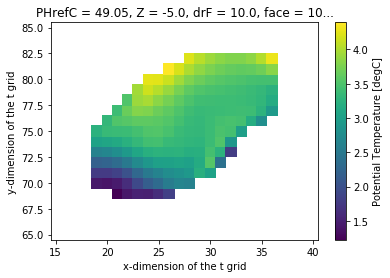

In [5]:
labrador['THETA'].isel(k=0,time=0).plot()

## Define the functions needed for the computation

In [6]:
def compute_potdens(ds):
    """ compute the potential density
    """
    # compute the Conservative Temperature from the model's potential temperature
    CT = gsw.CT_from_pt(ds['SALT'], ds['THETA'])
    z, lat = xr.broadcast(ds['Z'], ds['YC'])
    # compute pressure from depth
    p = gsw.p_from_z(z, lat)
    # compute in-situ temperature
    T = gsw.t_from_CT(ds['SALT'], CT, p)
    # compute potential density
    rho = gsw.pot_rho_t_exact(ds['SALT'], T, p, 0.)
    # create new dataarray
    darho = xr.full_like(ds['THETA'],0.)
    darho.name = 'RHO'
    darho.attrs['long_name'] = 'Potential Density ref at 0m'
    darho.attrs['standard_name'] = 'RHO'
    darho.attrs['units'] = 'kg/m3'
    darho.values = rho
    # filter special value
    ds['RHO'] = darho.where(darho > 1000)
    return ds

In [7]:
def compute_mld_rhocrit(ds):
    """ compute the Mixed Layer Depth with 0.03 kg/m3 density criterion 
    similar to De Boyer Montégut climatology
    """
    # anomaly is referenced to the -10 meters depth potential density
    # ECCO levels are -5m, -15m, so:
    ref = 0.5 *( ds['RHO'].sel(k=0) +  ds['RHO'].sel(k=1) )
    anom = ds['RHO'] - ref
    # compute mld as lowest point satisfying the condition
    mldr003 = ds['Z'].where(anom < 0.03).min(dim='k')
    # make it a positive number
    return - mldr003

In [8]:
def weighted_2d_avg(da):
    """ compute area-weighted average for data array
    """
    avg = (da * da['rA']).sum(dim=['i', 'j'], skipna=True) / \
           da['rA'].where(da.fillna(-999) != -999).sum(dim=['i', 'j'])
    return avg

## Let's crunch some numbers

Compute the potential density

In [9]:
labrador = compute_potdens(labrador)

Compute the mixed layer depth

In [10]:
mld = compute_mld_rhocrit(labrador)

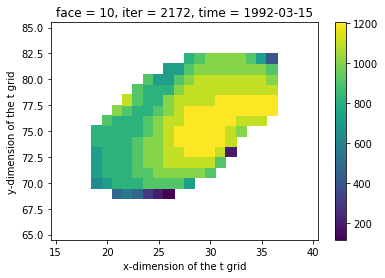

In [15]:
mld.isel(time=2).plot()

Compute the average mld over the central labrador sea

In [12]:
avgmld = weighted_2d_avg(mld)

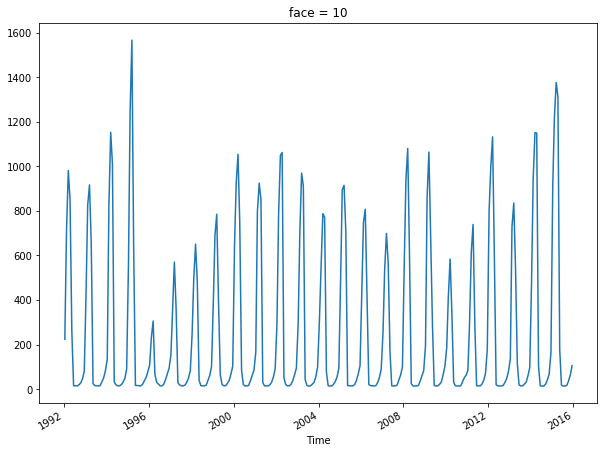

In [14]:
avgmld.plot(figsize=[10,7])

Extract the maximum mld value for each year and plot it:

In [18]:
maxmld = avgmld.groupby(avgmld.time.dt.year).max()

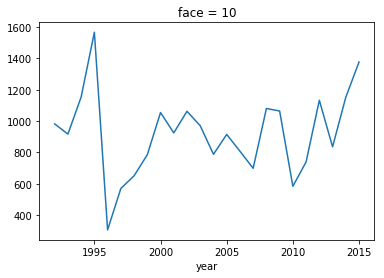

In [19]:
maxmld.plot()